# Linear Regression with TensorFlow

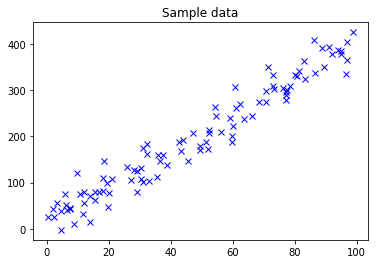

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.animation
from sklearn import linear_model

# Generate data
np.random.seed(42)
num_points = 100
a = 4
b = 7
sigma = 30
x = (np.random.rand(num_points) + 0) * 100
y = (a * x + b) + (np.random.randn(num_points) * sigma)

# Plot sample set
plt.plot(x, y, "bx");
plt.title("Sample data");

In [2]:
# Split the data into 2 sets
training_set_size = math.floor(num_points * 0.7)
x_train_orig = x[:training_set_size]
y_train_orig = y[:training_set_size]
x_test_orig = x[training_set_size:]
y_test_orig = y[training_set_size:]

# Normalise the data to avoid blow-ups
def normalise_array(a):
    m = a.mean()
    std = a.std()
    return m, std, (a - m)/std

x_train_mean, x_train_std, x_train = normalise_array(x_train_orig)
y_train_mean, y_train_std, y_train = normalise_array(y_train_orig)
x_test_mean, x_test_std, x_test = normalise_array(x_test_orig)
y_test_mean, y_test_std, y_test = normalise_array(y_test_orig)
print(f"Training set mean = {x_train_mean:.2f}, {y_train_mean:.2f}")
print(f"Training set stdev = {x_train_std:.2f}, {y_train_std:.2f}")

Training set mean = 46.75, 192.79
Training set stdev = 30.18, 117.37


In [3]:
# Placeholders are used to feed training inputs
tf_x = tf.placeholder("float", name="x") 
tf_y = tf.placeholder("float", name="y")
# Variables store trainable variables
tf_slope = tf.Variable(np.random.randn(), name="slope")
tf_intercept = tf.Variable(np.random.randn(), name="intercept")
# Inference function
tf_y_prediction = tf.add(tf.multiply(tf_slope, tf_x), tf_intercept)
# Loss function: mean squared error
tf_loss = tf.reduce_sum(tf.pow(tf_y_prediction - tf_y, 2)) / num_points
# Gradient descent optimiser
gradient_step_size = 0.1
optimizer = tf.train.GradientDescentOptimizer(gradient_step_size).minimize(tf_loss)

In [4]:
# Make the variables available in the execution environment
init = tf.global_variables_initializer()
# Start session and run graph
num_iterations = 20
history_loss = np.zeros(num_iterations)
history_slope = np.zeros(num_iterations)
history_intercept = np.zeros(num_iterations)
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_iterations):
        for (x_value, y_value) in zip(x_train, y_train):
            sess.run(optimizer, feed_dict={tf_x: x_value, tf_y: y_value})
        loss = sess.run(tf_loss, feed_dict={tf_x: x_train, tf_y: y_train})
        # Compute and store slope and intercept
        slope = sess.run(tf_slope) * y_train_std / x_train_std
        intercept = - slope * x_train_mean + sess.run(tf_intercept) * y_train_std + y_train_mean        
        history_loss[i] = loss
        history_slope[i] = slope
        history_intercept[i] = intercept        
print(f"Final intercept = {intercept:.2f}, slope = {slope:.2f}, loss = {loss:.2f}")

Final intercept = 36.46, slope = 3.57, loss = 0.04


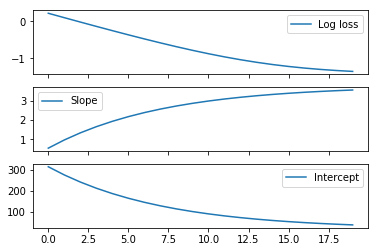

In [5]:
# Plot convergence history
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex='all')
ax1.plot(np.log10(history_loss), label='Log loss');
ax2.plot(history_slope, label='Slope');
ax3.plot(history_intercept, label='Intercept');
ax1.legend();
ax2.legend();
ax3.legend();

In [7]:
# Compare with scikit's regression output
print(f"TensorFlow empirical loss = {loss:.2f}, intercept = {intercept:.2f}, slope = {slope:.2f}")

regr = linear_model.LinearRegression()
regr.fit(x_train_orig.reshape(-1,1), y_train_orig.reshape(-1,1))
y0, y1 = regr.predict(np.array([0, 1]).reshape(-1,1))[:,0]
print(f"Scikit regression coefficients: {y0:.2f}, {y1-y0:.2f}")

TensorFlow empirical loss = 0.04, intercept = 36.46, slope = 3.57
Scikit regression coefficients: 15.85, 3.78


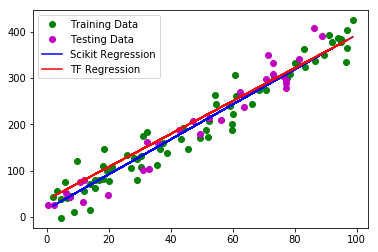

In [8]:
# Plot input data and regression line
plt.plot(x_train_orig, y_train_orig, "go", label="Training Data")
plt.plot(x_test_orig, y_test_orig, "mo", label="Testing Data")
y_regression = x_train_orig * (y1-y0) + y0
plt.plot(x_train_orig, y_regression, "b", label="Scikit Regression")
y_regression = x_train_orig * slope + intercept
plt.plot(x_train_orig, y_regression, "r", label="TF Regression")
plt.legend();

<IPython.core.display.Javascript object>


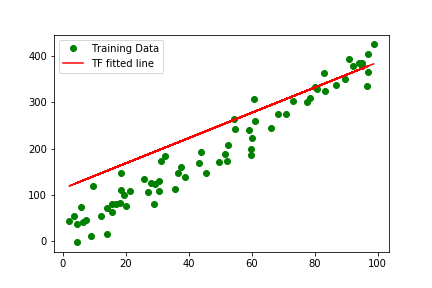

In [17]:
# Animated version showing convergence of the fitted line
%matplotlib notebook 
import matplotlib.pyplot as plt # this shouldn't be necessary

fig, ax = plt.subplots()
ax.plot(x_train_orig, y_train_orig, 'go', label='Training Data')
line, = ax.plot([], [], 'r', label='TF fitted line')
plt.legend()

def update_animation(i):
    line.set_data(x_train_orig, x_train_orig * history_slope[i] + history_intercept[i])
    return line,

def init_animation():
    update_animation(0)
    return line,

anim = matplotlib.animation.FuncAnimation(fig, update_animation, frames=np.arange(0, num_iterations), 
                                   init_func=init_animation, interval=1000, blit=True);